### Master of Applied Artificial Intelligence

**Course: TC4033 - Computational Vision for Images and Video**

<img src="./../assets/logo.png" alt="Image Alt Text" width="500"/>

**Image enhancement algorithms in the spatial domain**

Tutor: Dr. Gilberto Ochoa


Team members:
* Alfonso de Lucas Espinosa - A01795118
* Ignacio Jose Aguilar Garcia - A00819762
* Alejandro Calderon Aguilar - A01795353
* Ricardo Mar Cupido - A01795394
* Mario Fonseca Martinez - A01795228


### Introduction


#### Spatial filtering

Filtering refers to passing, modifying, or rejecting specified frecuency components of an image.

Spatial filtering modifies an image by replacing the value of each pixel by a function of the values of the pixel and its neighbors.


#### Spatial correlation and convolution

**Spatial correlation** consist of moving the center of a kernel over an image and computing the sum of products at each location.

<img src="./data/linear_spatial_filtering.png" alt="Linear spatial filtering" width="200"/>

*where:*
* *f* : image of size *M* x *N*
* *w*: kernel , filter of size *m* x *n*
* (*x*, *y*): any point in the image
* *g*(*x*. *y*): the output
* s is the row index relative to the kernel's center (e.g., −1,0,1 for a 3×3 kernel).
* t is the column index relative to the kernel's center (e.g., −1,0,1 for a 3×3 kernel).


Correlation is a function of *displacement of the filter kernel relative to the image*



**Spatial convolution** is the same, except that the correlation kernel is rotated by 180º.


#### Padding
Kernel of size *m* x *n* we pad the image with a minimum of (m-1)/2 rows of 0's at the top and bottom and (n-1)/2 columns of 0's on the left and right.



#### Kernel dimensions

<img src="https://miro.medium.com/v2/resize:fit:1052/0*Asw1tDuRs3wTjwi7.gif" alt="Linear spatial filtering" width="200"/>

in correlation and convolution every element of *w* visits every pixel in *f*

This requires of two configurations, the *starting configuration* and the *ending configuration*

the starting configuration be such that the right, lower corner of the kernel coincides with the origin of the image.

the ending configuration will be the top left corner of the kernel coinciding with the lower right corner of the image.


#### Edge Detection


With Edge Detection algorithms such as prewitt, sobel and laplaciano, are essential for image segmentation.

Edge detection involves the use of filters (P.E, n x n) kernel matrices to mask irrelevant data and keep image edges. the kernel size influences the image's sharpness

* 2x2 or 3x3 yielding sharp edges
* 5*5 producing blurred edges


Example of a matrix multiplication of image pixes with a kernel of 3 x 3 
<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*2U8rAjJ9r22WPNM75SbFxg.png" alt="Edge Detection Using Prewitt Algorithm" width="500"/>


### Edge detection types

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*mHO2ERxjSGTMLBgLVrCUHg.png" alt="Edge detection types" width="500"/>


the following image show two regions of constant intensity separated by an ideal ramp edge, where we can see how the edge comports with the first derivative (gradient) and second derivative (gaussian).

<img src="data/notebook_src/region_intensity.png" alt="Gradient equation" width="300"/>


#### Gradient Based

1. For finding edge strength and direction at an arbitrary location (*x*, *y*) of an image f we use:

<img src="data/notebook_src/gradient_equation.png" alt="Gradient equation" width="200"/>

2. When evaluated for all aplicable values of *x* and *y* $\nabla$*f*(*x*,*y*) becomes a vector image. The **Magnitude**, *M*(*x*, *y*), of this gradient vector at a point (*x*, *y*) is given by its Euclidean vector norm:

<img src="data/notebook_src/euclidean_vector_norm.png" alt="Gradient equation" width="200"/>

this is the *value* of the rate of change in the direction of the gradient vector at point (*x*, *y*).

g<sub>x</sub> and g<sub>y</sub> are arrays of the same size as *f*.


3. The direction of the gradient vector at a point (*x*, *y*) is given by

<img src="data/notebook_src/gradient_direction_equation.png" alt="Gradient equation" width="200"/>


Angles are measured in the counterclockwise direction with respect to the x-axis, it is also a image of the same size as *f*

the direction of an edge at a point is orthogonal to the gradient vector at that point.
the edge vector is called the *edge normal*, when the vector is normalized to unit length by dividing it by its magnitude, the resulting vector is referred as the *edge unit normal*






#### Gaussian Based





### Importing libraries

In [25]:
from matplotlib import image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

### Loading Images

In [26]:
# Loading images
moon = Image.open("data/moon.jpg")
fingerprint = Image.open("data/fingerprint.png")
plans = Image.open("data/plans.jpg")
dragon = Image.open("data/dragon.png")
pet = Image.open("data/pet_image.png")

In [47]:
gradient_labels = ["Original image", "Gradient image", "Gradient Direction"]
def plot_images(images=[], labels=[], nrows=1, ncols=2, figsize=(12,8), cmap="gray"):
    """
    plot a set of images
    """
    # set the subplots
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    # Iterate over each axis defined in M*N as flat
    for i, ax in enumerate(axs.flat):
        # validates that the dimensions of axs fits with images array parameter
        if i < len(images):
            # plot the image
            ax.imshow(images[i], cmap=cmap)
            # if there are labels defined then set a title
            if len(labels) > 0:
                ax.set_title(labels[i])
            # dont show the axis ticks 
            ax.axis("off")
        else:
            # dont show an empty plot
            ax.axis("off")
    # fits the plots 
    plt.tight_layout()
    plt.show()
    
def set_xy_kernel(gaussian_1d, x_derivative):
    gaussian_1d = np.array(gaussian_1d, np.float32)
    x_derivative = np.array(x_derivative, np.float32)
    s_x = np.outer(gaussian_1d, x_derivative)
    s_y = np.outer(x_derivative, gaussian_1d)
    return s_x , s_y
    
def padding(image):
    padded_image = np.pad(image, ((1, 1), (1, 1)), mode="constant", constant_values=(0,0))
    return padded_image

def conv2d(image, kernel):
    image = np.array(image, dtype=np.float32)
    # add padding to the image
    image = padding(image)
    
    # get the new shape of kenel and image shape
    shape = kernel.shape + tuple(np.subtract(image.shape, kernel.shape) + 1)
    
    # create a sliding window view of the image, 
    # strides control how many bytes are needed to move the next element along each dimension (image_width * element_size, element_size)
    # passing the image 2d, the shape of the sliding window view (kernel height, kernel width, output_height, output_width)
    image_conv2 = np.lib.stride_tricks.as_strided(image, shape=shape,strides= image.strides * 2)
    
    # using Eisten summation, it performs a tensor contraction where
    # kernel shape is Kh x Kw
    # and image_conv2 shape is (Kh x Kw x Oh * Ow)
    # dimensions i and j correspond to the kernel's size
    # dimensions j, l correspond to the sliding window postions.
    # the operation ijkl -> kl
    # multiply the kernel ij with each corresponding patch (ij) in image_conv2 array
    # the sum over i and j dimensions for each sliding window at every position (k, l)
    # the result is a 2D array (kl) same shape as the output of the convolution
    return np.einsum("ij, ijkl->kl", kernel, image_conv2)


### 1. Line Detectors

#### 1.1 Prewitt

<img src="data/prewitt_kernel.png" height="100"/>

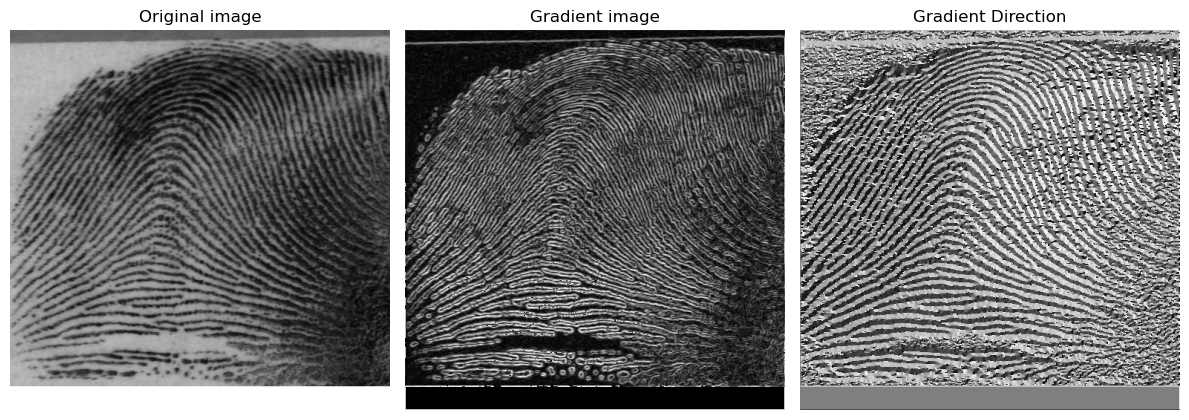

In [49]:
def prewittx(image):
    """
    Applies the Prewitt operator to an input image to detect edges in the x-direction.
    Parameters:
    image (numpy.ndarray): The input image on which to apply the Prewitt operator.
    Returns:
    numpy.ndarray: The magnitude of the gradient of the image after applying the Prewitt operator.
    """
    # Define Prewitt kernels for x and y directions
    s_x, s_y = set_xy_kernel([1,1,1], [-1, -0, 1])
    
    # Apply convolution to get gradients in x and y directions
    G_x = conv2d(image, s_x)
    G_y = conv2d(image, s_y)
    
    # Compute the magnitude of the gradient
    gradient_image = np.sqrt(np.power(G_x, 2) + np.power(G_y, 2))
    
    # Compute the direction of the gradient (y,x)
    gradient_direction = np.arctan2(G_y, G_x)
    
    return np.uint8(gradient_image), gradient_direction

# Convert the fingerprint image to grayscale
fingerprint_gray = fingerprint.convert("L")

# Apply the Prewitt operator to the grayscale image
gradient_image, gradient_direction = prewittx(fingerprint_gray)

# Plot the original image and the Prewitt edge-detected image
plot_images([fingerprint_gray, gradient_image, gradient_direction ],labels= gradient_labels, ncols=3)

**Algorithmic Complexity**

The algorithmic complexity of this method is O(n), as the image is traversed pixel by pixel in this method.


**Reference**

https://www.geeksforgeeks.org/edge-detection-using-prewitt-scharr-and-sobel-operator/

#### 1.2 Sobel

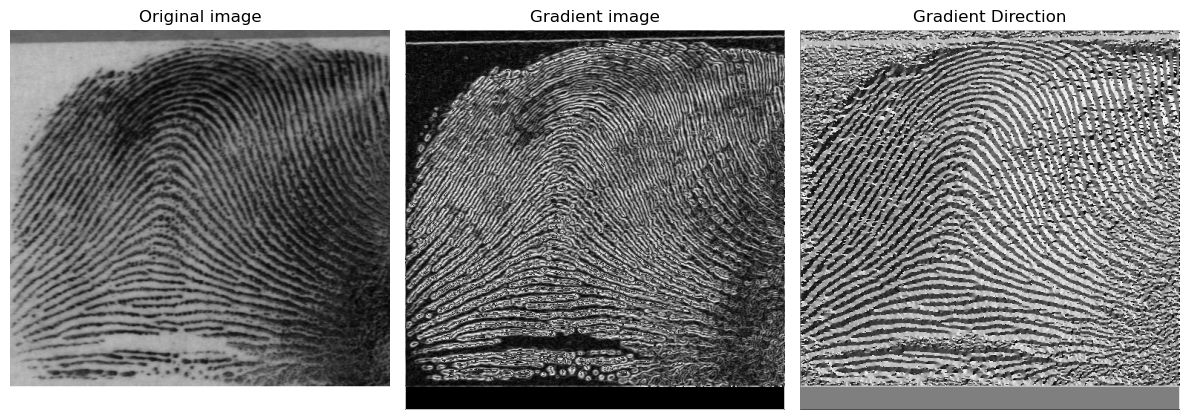

In [51]:
def sobel(image):
    """
    Applies the Sobel operator to an input image to detect edges.
    Parameters:
    image (numpy.ndarray): The input image on which to apply the Sobel operator. 
                           It should be a 2D grayscale image.
    Returns:
    tuple: A tuple containing:
        - M (numpy.ndarray): The magnitude of the gradient, normalized to be in the range [0, 1].
        - theta (numpy.ndarray): The direction of the gradient in radians.
    """
    # Define Sobel kernels for x and y directions
    s_x, s_y = set_xy_kernel([1,2,1], [-1, 0, 1])
    
    # Apply convolution to get gradients in x and y directions
    G_x = conv2d(image, s_x)
    G_y = conv2d(image, s_y)
    
    # Compute the magnitude of the gradient
    gradient_image = np.sqrt(np.power(G_x,2) + np.power(G_y, 2))

    # Compute the direction of the gradient
    gradient_direction = np.arctan2(G_y, G_x)

    return np.uint8(gradient_image), gradient_direction

# Convert the fingerprint image to grayscale
fingerprint_gray = fingerprint.convert("L")

# Apply the Sobel operator to the grayscale image
sobel_gradient_image, sobel_gradient_direction = sobel(fingerprint_gray)

# Plot the original image, the Sobel edge-detected image, and the gradient direction
plot_images([fingerprint_gray, sobel_gradient_image, sobel_gradient_direction], labels=gradient_labels, ncols=3)

**Algorithmic Complexity**

The algorithmic complexity of this method is O(n), as the image is traversed pixel by pixel in this method.

**Reference:**

https://medium.com/@haidarlina4/sobel-vs-canny-edge-detection-techniques-step-by-step-implementation-11ae6103a56a


#### 1.3 Laplaciano

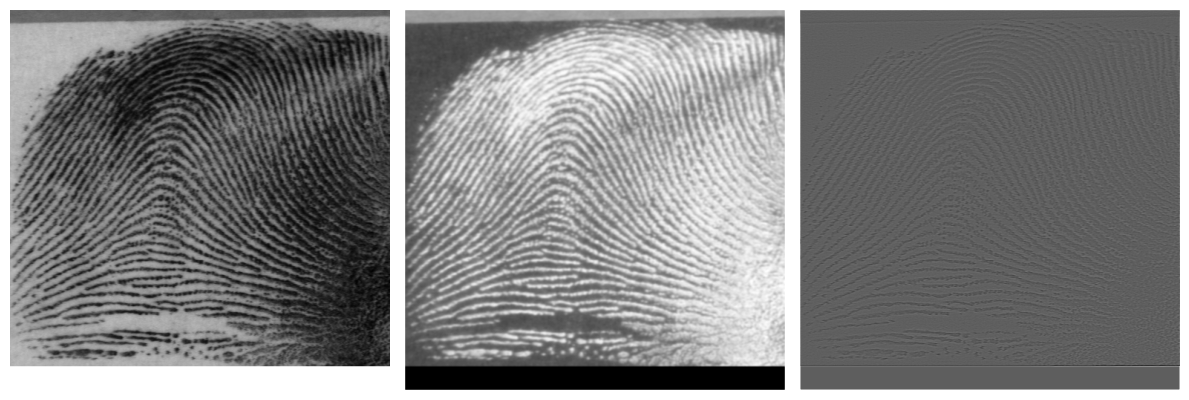

In [52]:
#Laplacian 
def laplacian(image):
    kernel1 = np.array([
        [0, -1, 0],
        [-1, 0, -1],
        [0, -1, 0]
    ], dtype=np.float32)
    
    kernel2 = np.array([
        [-1,-1,-1],
        [-1, 8, -1],
        [-1,-1,-1]
    ], dtype=np.float32)
    
    output_image = conv2d(image, kernel1)
    output_image2 = conv2d(image, kernel2)
    return output_image, output_image2

fingerprint_gray = fingerprint.convert("L")
laplacian_image1, laplacian_image2 = laplacian(fingerprint_gray)
plot_images([fingerprint_gray, laplacian_image1, laplacian_image2], ncols=3)

*Explain which algorithm is more efficient*

### 2. Image enhancement algorithms
Implement an image enhancement or enhancement algorithm through an algorithm in which the lines are extracted from the image and then the difference with the original image is applied, multiplying the pixels of the “mask” image (the lines found) by a alpha factor greater than 1.




Image enhancement is a process aimed at improving the visual quality of an image by emphasizing certain features or correcting visual defects. One effective technique for enhancement involves the extraction of lines from an image, followed by their manipulation and integration with the original image. The following steps outline the process of enhancing an image using line extraction:

* Finding the Lines: The first thing we do is extract the lines or edges from the image. Think of this as identifying the outlines of objects or areas of sharp contrast. Techniques like the Sobel operator or Canny edge detection are great tools for this and can create a "mask" that highlights just the edges of the original image (Gonzalez & Woods, 2018).

* Spot the Difference: Next, we calculate the difference between the original image and the mask. This helps us separate the smoother parts of the image from the sharper, more defined edges.

* Enhance the Lines: Once we have the mask with the lines, we make those lines pop by multiplying their intensity with a factor called alpha. This alpha factor, which is greater than 1, acts like a volume knob for the edges, making them brighter or more defined.

* Blend It All Together: Finally, the enhanced lines are added back to the original image. The result is an improved image where the edges are sharper, and the details stand out more clearly (Russ & Neal, 2015).

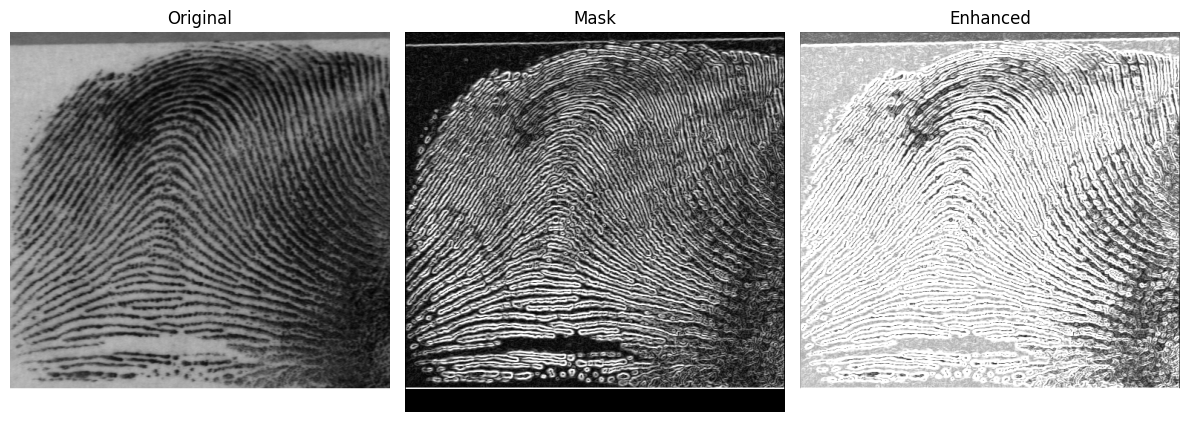

In [9]:
def enhance_image(image, mask, alpha=1.5):
    """
    Enhance the image by extracting lines and applying the difference with the original image.
    
    Parameters:
    - image: Original image (PIL Image)
    - mask: Mask image (numpy array)
    - alpha: Multiplication factor for the mask image
    
    Returns:
    - Enhanced image (numpy array)
    """
    # Convert the original image to numpy array
    image_array = np.array(image, dtype=np.float32) / 255.0
    
    # Multiply the mask by the alpha factor
    enhanced_mask = mask * alpha
    
    # Apply the difference with the original image
    enhanced_image = image_array + enhanced_mask
    
    # Clip the values to be in the range [0, 1]
    enhanced_image = np.clip(enhanced_image, 0, 1)
    
    return enhanced_image

# Convert the fingerprint image to grayscale
fingerprint_gray = fingerprint.convert("L")

# Use the Sobel operator to extract the lines
sobel_image, _ = sobel(fingerprint_gray)

# Enhance the image using the extracted lines
enhanced_image = enhance_image(fingerprint_gray, sobel_image, alpha=1.5)

# Plot the original, mask, and enhanced images
plot_images([fingerprint_gray, sobel_image, enhanced_image], labels=["Original", "Mask", "Enhanced"], ncols=3)

As demonstrated in the code below, the result of this process is a visually enhanced image that retains the original content while emphasizing the edges and details, this as we can saw in the previous image, the lines are more defined and the image is more clear, in this case the thumb is more defined and the lines of the hand are more clear.

### 3. A Case Study in Medical Imaging (PET images)

PET (Positron Emission Tomography) images are a type of medical imaging that provides information about the metabolic activity of tissues in the body. These images are used in various medical fields, including oncology, neurology, and cardiology, to diagnose and monitor diseases.

In this case study, we will explore the application of image enhancement techniques to PET images. Specifically, we will focus on enhancing the edges and details in PET images to improve their visual quality and diagnostic value.

For this purpose, we will use the following steps:

* Load the PET image: We will start by loading a PET image from a medical dataset.
* Enhance the image: We will apply image enhancement techniques to the PET image to improve its visual quality and highlight important features.
* Visualize the results: We will compare the original PET image with the enhanced image to evaluate the effectiveness of the enhancement techniques.

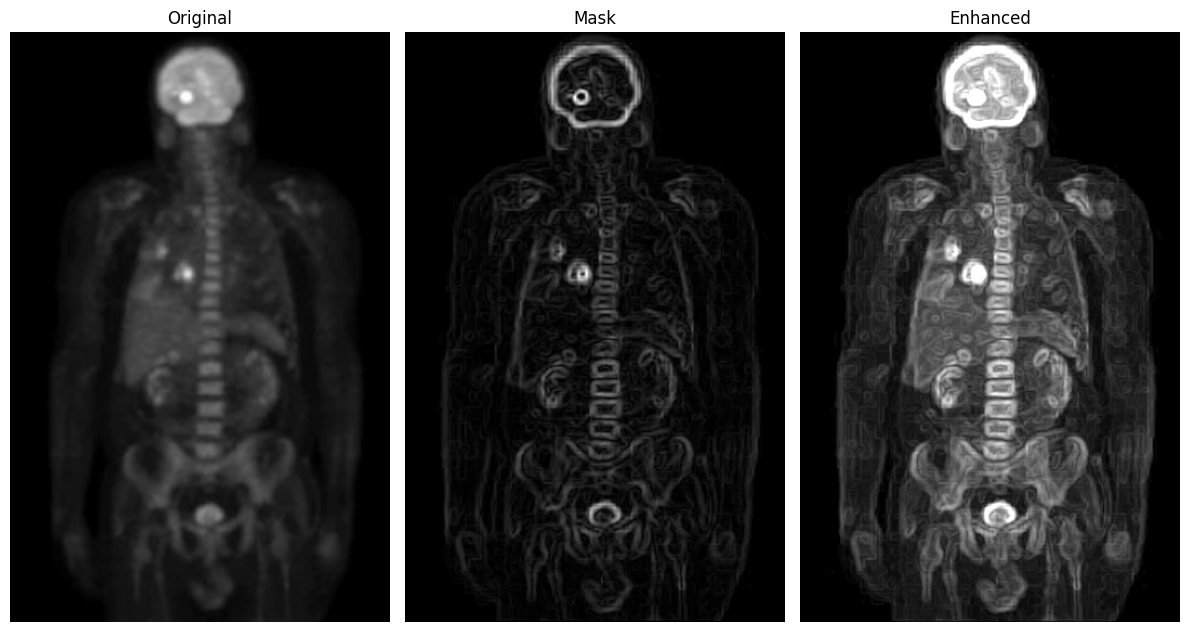

In [10]:
pet_gray = pet.convert("L") 



### Conclusion

*Team conclusion*

### References

* K, H. (2024, February 29). Image Preprocessing with Computer Vision: Edge Detection Using Prewitt Algorithm. Medium. [https://medium.com/@hassanjadoon2001/image-preprocessing-with-computer-vision-edge-detection-using-prewitt-algorithm-d4f00a2f1565]
* Russ, J. C., & Neal, F. B. (2015). The Image Processing Handbook. In CRC Press eBooks. [https://doi.org/10.1201/b18983]
Gonzalez, R. C., & Woods, R. E. (2018). Digital Image Processing, Global Edition. Pearson UK.
* Lina-Haidar. (n.d.). Edge-Detection-Techniques-Sobel-vs.-Canny/sobel_with_numpy.py at main · lina-haidar/Edge-Detection-Techniques-Sobel-vs.-Canny. GitHub. [https://github.com/lina-haidar/Edge-Detection-Techniques-Sobel-vs.-Canny/blob/main/sobel_with_numpy.py]

